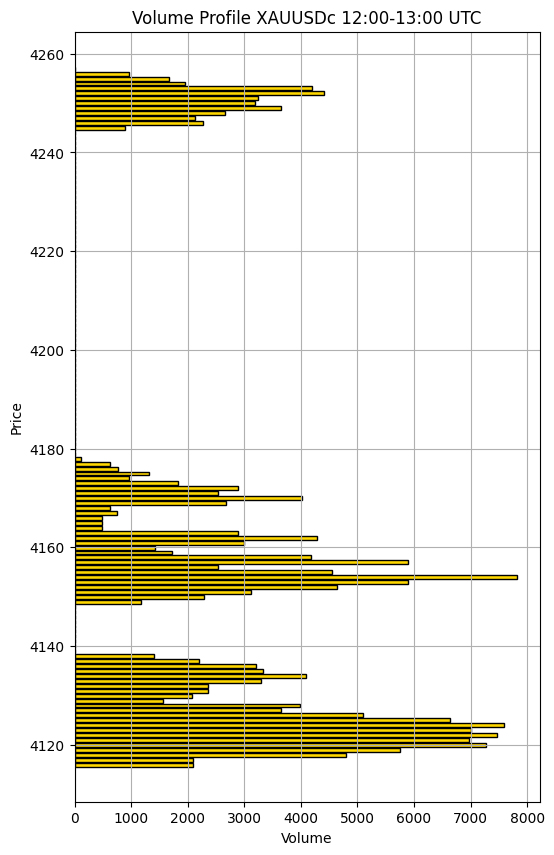

True

In [8]:
import MetaTrader5 as mt5
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, timezone

# ------------------------------
# 1. Initialize MT5
# ------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
    exit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M1  # 1-minute bars for accurate volume profile
utc_offset = timezone.utc

# ------------------------------
# 2. Define date range
# ------------------------------
# Example: last 7 days
end_date = datetime.now(tz=utc_offset)
start_date = end_date - timedelta(days=7)

# ------------------------------
# 3. Fetch data
# ------------------------------
rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
if rates is None:
    print("No data fetched")
    mt5.shutdown()
    exit()

# Convert to DataFrame
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
df.set_index('time', inplace=True)

# ------------------------------
# 4. Filter for 12:00 - 13:00 UTC each day
# ------------------------------
df_hour = df.between_time('12:00', '13:00')

# ------------------------------
# 5. Build volume profile
# ------------------------------
def volume_profile(df_hour, price_step=1):
    """Build a simple volume profile (price vs total volume)"""
    prices = np.arange(df_hour['low'].min(), df_hour['high'].max() + price_step, price_step)
    volume_by_price = np.zeros_like(prices, dtype=float)

    for i, price in enumerate(prices):
        # Sum volume where price touched this level (including wicks)
        mask = (df_hour['low'] <= price) & (df_hour['high'] >= price)
        volume_by_price[i] = df_hour.loc[mask, 'tick_volume'].sum()

    return prices, volume_by_price

prices, volumes = volume_profile(df_hour, price_step=1)

# ------------------------------
# 6. Plot volume profile
# ------------------------------
plt.figure(figsize=(6, 10))
plt.barh(prices, volumes, height=0.8, color='gold', edgecolor='black')
plt.xlabel("Volume")
plt.ylabel("Price")
plt.title(f"Volume Profile {symbol} 12:00-13:00 UTC")
plt.grid(True)
plt.show()

# ------------------------------
# 7. Shutdown MT5
# ------------------------------
mt5.shutdown()


In [3]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
    exit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1
n_bars = 500

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, n_bars)
mt5.shutdown()  # shutdown immediately after fetching data

if rates is None:
    print("Failed to get data")
    exit()

# -------------------------------
# 2. Convert to DataFrame and filter 12 UTC
# -------------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['hour'] = df['time'].dt.hour
df_12_utc = df[df['hour'] == 12].copy()

# -------------------------------
# 3. Create Volume Profile per candle
# -------------------------------
volume_profiles = []

bin_size = 0.25  # 0.25 price units per bin

for idx, row in df_12_utc.iterrows():
    o, h, l, c, vol = row['open'], row['high'], row['low'], row['close'], row['tick_volume']

    # Generate price bins
    bins = np.arange(l, h + bin_size, bin_size)
    
    # Assign tick volume evenly to bins (simple approach)
    bin_vols = np.full(len(bins), vol / len(bins))  # uniform allocation
    
    profile_df = pd.DataFrame({
        'time': row['time'],
        'price_bin': bins,
        'volume': bin_vols
    })
    
    volume_profiles.append(profile_df)

# Combine all profiles
volume_profile_df = pd.concat(volume_profiles, ignore_index=True)

# -------------------------------
# 4. Result
# -------------------------------
print(volume_profile_df.head(20))


                  time  price_bin      volume
0  2025-10-31 12:00:00   4009.075  186.372727
1  2025-10-31 12:00:00   4009.325  186.372727
2  2025-10-31 12:00:00   4009.575  186.372727
3  2025-10-31 12:00:00   4009.825  186.372727
4  2025-10-31 12:00:00   4010.075  186.372727
5  2025-10-31 12:00:00   4010.325  186.372727
6  2025-10-31 12:00:00   4010.575  186.372727
7  2025-10-31 12:00:00   4010.825  186.372727
8  2025-10-31 12:00:00   4011.075  186.372727
9  2025-10-31 12:00:00   4011.325  186.372727
10 2025-10-31 12:00:00   4011.575  186.372727
11 2025-10-31 12:00:00   4011.825  186.372727
12 2025-10-31 12:00:00   4012.075  186.372727
13 2025-10-31 12:00:00   4012.325  186.372727
14 2025-10-31 12:00:00   4012.575  186.372727
15 2025-10-31 12:00:00   4012.825  186.372727
16 2025-10-31 12:00:00   4013.075  186.372727
17 2025-10-31 12:00:00   4013.325  186.372727
18 2025-10-31 12:00:00   4013.575  186.372727
19 2025-10-31 12:00:00   4013.825  186.372727


MT5 initialized
                         open      high       low     close  tick_volume  \
time                                                                       
2025-10-31 07:00:00  4013.097  4025.306  4007.446  4021.041        19139   
2025-10-31 08:00:00  4021.002  4026.871  4006.614  4010.481        18134   
2025-10-31 09:00:00  4010.442  4014.320  3998.795  4008.531        16934   
2025-10-31 10:00:00  4008.522  4016.816  4003.540  4007.458        14173   
2025-10-31 11:00:00  4007.413  4011.227  4001.697  4010.585        13371   

                     spread  real_volume  
time                                      
2025-10-31 07:00:00     160            0  
2025-10-31 08:00:00     160            0  
2025-10-31 09:00:00     160            0  
2025-10-31 10:00:00     160            0  
2025-10-31 11:00:00     160            0  


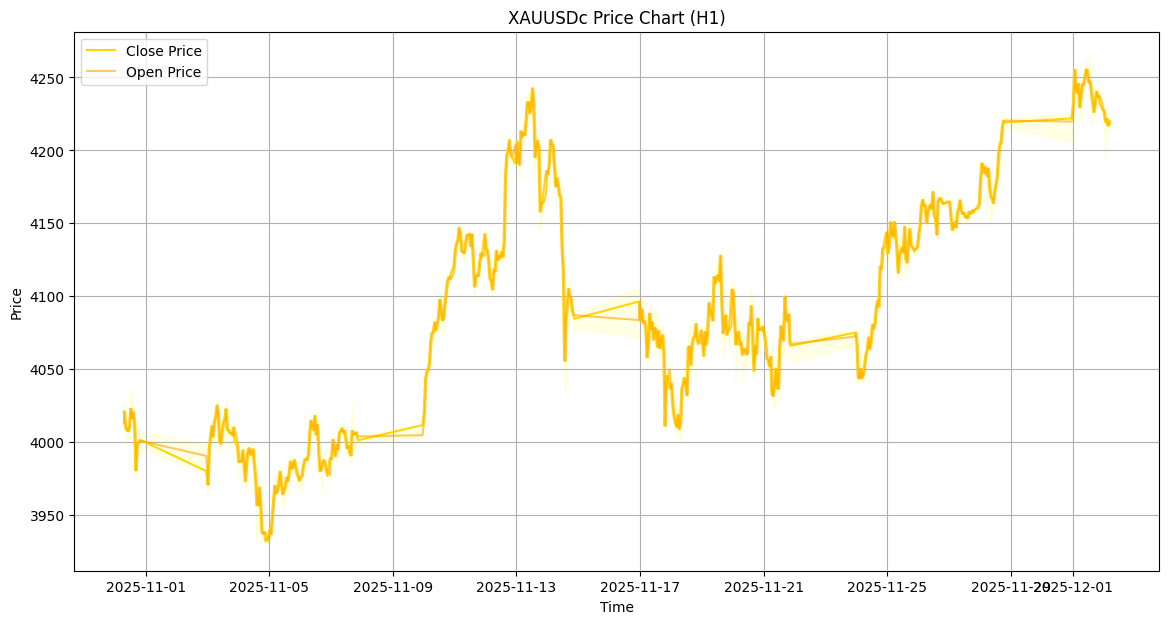

True

In [4]:
import MetaTrader5 as mt5
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------------------
# 1. Initialize MT5 connection
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
else:
    print("MT5 initialized")

# -------------------------------
# 2. Set symbol and timeframe
# -------------------------------
symbol = "XAUUSDc"  # Your symbol in MT5
timeframe = mt5.TIMEFRAME_H1  # 1-hour candles
n_bars = 500  # Number of bars to fetch

# -------------------------------
# 3. Fetch data
# -------------------------------
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, n_bars)

if rates is None:
    print("Failed to get data")
    mt5.shutdown()
    exit()

# -------------------------------
# 4. Convert to DataFrame
# -------------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

print(df.head())

# -------------------------------
# 5. Plot the chart
# -------------------------------
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Close Price', color='gold')
plt.plot(df.index, df['open'], label='Open Price', color='orange', alpha=0.6)
plt.fill_between(df.index, df['low'], df['high'], color='yellow', alpha=0.1)
plt.title('XAUUSDc Price Chart (H1)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 6. Shutdown MT5
# -------------------------------
mt5.shutdown()


In [6]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
    exit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1
n_bars = 500

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, n_bars)
mt5.shutdown()  # shutdown immediately after fetching data

if rates is None:
    print("Failed to get data")
    exit()

# -------------------------------
# 2. Convert to DataFrame and filter 12 UTC
# -------------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['hour'] = df['time'].dt.hour
df_12_utc = df[df['hour'] == 12].copy()

# -------------------------------
# 3. Create Volume Profile per candle
# -------------------------------
volume_profiles = []

bin_size = 0.25  # 0.25 price units per bin

for idx, row in df_12_utc.iterrows():
    o, h, l, c, vol = row['open'], row['high'], row['low'], row['close'], row['tick_volume']

    # Generate price bins
    bins = np.arange(l, h + bin_size, bin_size)
    
    # Assign tick volume evenly to bins (simple approach)
    bin_vols = np.full(len(bins), vol / len(bins))  # uniform allocation
    
    profile_df = pd.DataFrame({
        'time': row['time'],
        'price_bin': bins,
        'volume': bin_vols
    })
    
    volume_profiles.append(profile_df)

# Combine all profiles
volume_profile_df = pd.concat(volume_profiles, ignore_index=True)

# -------------------------------
# 4. Result
# -------------------------------
print(volume_profile_df.head(20))


                  time  price_bin      volume
0  2025-10-31 12:00:00   4009.075  186.372727
1  2025-10-31 12:00:00   4009.325  186.372727
2  2025-10-31 12:00:00   4009.575  186.372727
3  2025-10-31 12:00:00   4009.825  186.372727
4  2025-10-31 12:00:00   4010.075  186.372727
5  2025-10-31 12:00:00   4010.325  186.372727
6  2025-10-31 12:00:00   4010.575  186.372727
7  2025-10-31 12:00:00   4010.825  186.372727
8  2025-10-31 12:00:00   4011.075  186.372727
9  2025-10-31 12:00:00   4011.325  186.372727
10 2025-10-31 12:00:00   4011.575  186.372727
11 2025-10-31 12:00:00   4011.825  186.372727
12 2025-10-31 12:00:00   4012.075  186.372727
13 2025-10-31 12:00:00   4012.325  186.372727
14 2025-10-31 12:00:00   4012.575  186.372727
15 2025-10-31 12:00:00   4012.825  186.372727
16 2025-10-31 12:00:00   4013.075  186.372727
17 2025-10-31 12:00:00   4013.325  186.372727
18 2025-10-31 12:00:00   4013.575  186.372727
19 2025-10-31 12:00:00   4013.825  186.372727


MT5 initialized


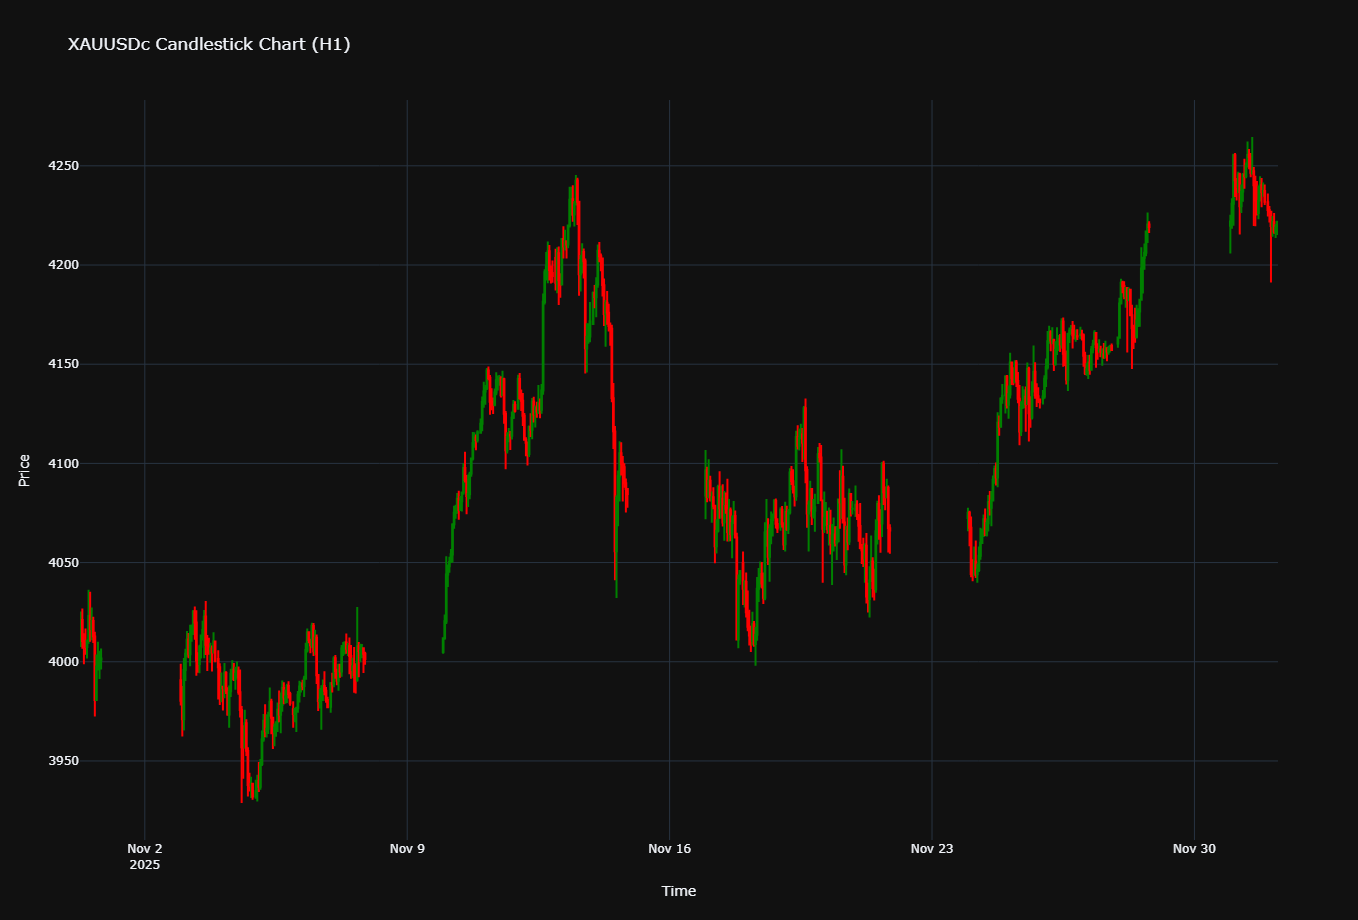

True

In [7]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
    exit()
else:
    print("MT5 initialized")

# -------------------------------
# 2. Fetch historical data
# -------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1  # 1-hour candles
n_bars = 500

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, n_bars)
if rates is None:
    print("Failed to get data")
    mt5.shutdown()
    exit()

# -------------------------------
# 3. Convert to DataFrame
# -------------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 4. Plot candlestick chart
# -------------------------------
fig = go.Figure(
    data=[
        go.Candlestick(
            x=df['time'],
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            increasing_line_color='green',
            decreasing_line_color='red'
        )
    ]
)

fig.update_layout(
    title=f'{symbol} Candlestick Chart (H1)',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    width=1600,  # increased width
    height=900   # increased height
)

fig.show()

# -------------------------------
# 5. Shutdown MT5
# -------------------------------
mt5.shutdown()


MT5 initialized


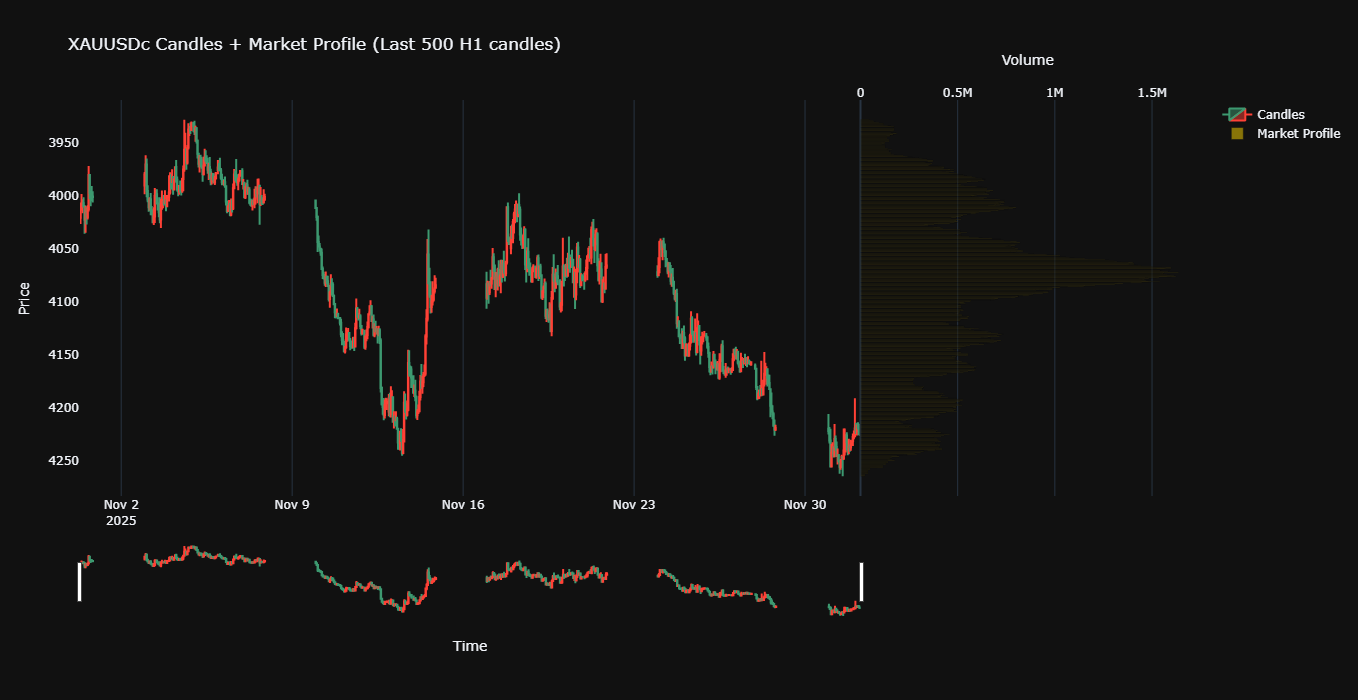

True

In [4]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()
    exit()
else:
    print("MT5 initialized")

# -------------------------------
# 2. Fetch last N candles
# -------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1
num_bars = 500  # number of candles

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
if rates is None or len(rates) == 0:
    print("No data fetched")
    mt5.shutdown()
    exit()

# Convert to DataFrame
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df[['time', 'open', 'high', 'low', 'close', 'tick_volume']]

# -------------------------------
# 3. Build Market Profile
# -------------------------------
bin_size = 0.25
price_min = df['low'].min()
price_max = df['high'].max()
bins = np.arange(price_min, price_max + bin_size, bin_size)

# Allocate tick volume to bins
mp_dict = {}
for _, row in df.iterrows():
    candle_bins = bins[(bins >= row['low']) & (bins <= row['high'])]
    for b in candle_bins:
        mp_dict[b] = mp_dict.get(b, 0) + row['tick_volume']

mp_df = pd.DataFrame(list(mp_dict.items()), columns=['price', 'volume'])
mp_df.sort_values('price', inplace=True)

# -------------------------------
# 4. Plot Candles + Market Profile
# -------------------------------
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(
    x=df['time'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Candles'
))

# Market Profile as horizontal bars
fig.add_trace(go.Bar(
    x=mp_df['volume'],
    y=mp_df['price'],
    orientation='h',
    marker_color='gold',
    name='Market Profile',
    opacity=0.5,
    xaxis='x2'
))

# Layout with secondary x-axis for volume
fig.update_layout(
    title=f'{symbol} Candles + Market Profile (Last {num_bars} H1 candles)',
    yaxis=dict(title='Price', autorange='reversed'),
    xaxis=dict(domain=[0, 0.7], title='Time'),
    xaxis2=dict(domain=[0.7, 1.0], title='Volume', anchor='y', side='top'),
    template='plotly_dark',
    width=1000,
    height=700
)

fig.show()

# -------------------------------
# 5. Shutdown MT5
# -------------------------------
mt5.shutdown()
